# PyTorch MLP Implementation

- PyTorch is an open source machine learning library based on the Torch library
- PyTorch defines a class called Tensor (torch.Tensor) to store and operate on homogeneous multidimensional rectangular arrays of numbers (matrix).
- PyTorch Tensors are similar to NumPy Arrays, but can also be operated on a CUDA-capable Nvidia GPU. PyTorch supports various sub-types of Tensors.



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import time

## Dataset Creation

- X: 300x2
- Y: 3

In [ ]:
def load_data(seed=1984):
    np.random.seed(seed)
    N = 100
    DIM = 2
    CLS_NUM = 3

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

x: (300, 2)
t: (300, 3)


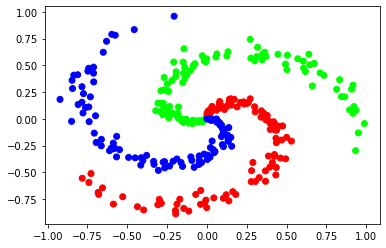

In [ ]:
x, t = load_data()
print(f"x: {x.shape}")
print(f"t: {t.shape}")

plt.scatter(x[:,0], x[:,1], color=t)
plt.show()

## Define Model Structure


In [ ]:
class TwoLayersNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayersNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        # Default PyTorch layer is initialized with a normal distribution
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_normal_(self.hidden_layer.weight)  # Xavier Initialization
        # nn.init.kaiming_normal_(self.hidden_layer.weight) # He Initialization
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm = nn.BatchNorm1d(num_features=10)

    def forward(self, inputs):
        out = self.hidden_layer(inputs)
        out = self.batchnorm(out)
        out = self.sigmoid(out)
        out = self.dropout(out)

        out = self.output_layer(out)

        return out

## Model Instantiation

In [ ]:
hidden_dim = 10
output_dim = 3
input_dim = 2

lr = 1

criterion = nn.CrossEntropyLoss()
model = TwoLayersNN(input_dim, hidden_dim, output_dim)
optimizer = optim.SGD(model.parameters(), lr)

# Model Train

In [ ]:
epoch = 200
batch_size = 30
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(epoch):
    model.train()

    # Shuffle data
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        optimizer.zero_grad()
        start_t = time.perf_counter()
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # Numpy to Tensor
        batch_x = torch.Tensor(batch_x)
        batch_t = torch.Tensor(batch_t.argmax(axis=1)).type(torch.LongTensor)

        output = model(batch_x)
        loss = criterion(output, batch_t)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) # Gradient clipping
        optimizer.step()

        # # Weight Clipping
        # for p in model.parameters():
        #   p.data.clamp_(-0.01, 0.01)

        total_loss += loss
        loss_count += 1

        ent_t = time.perf_counter()
        iter_time = ent_t-start_t
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            output = output.data.numpy()
            pred = np.argmax(output, axis=1)
            acc = np.sum(pred==batch_t.data.numpy())/batch_size

            print(f"Epoch: {epoch} || Iter: {iters}/{max_iters} || Accuracy: {acc:.2f} || AverageLoss: {avg_loss:.4f} || Elapsed: {iter_time:.6f}")
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0


Epoch: 0 || Iter: 9/10 || Accuracy: 0.53 || AverageLoss: 1.1416 || Elapsed: 0.000805
Epoch: 1 || Iter: 9/10 || Accuracy: 0.47 || AverageLoss: 0.9415 || Elapsed: 0.000760
Epoch: 2 || Iter: 9/10 || Accuracy: 0.60 || AverageLoss: 0.8835 || Elapsed: 0.000773
Epoch: 3 || Iter: 9/10 || Accuracy: 0.57 || AverageLoss: 0.9084 || Elapsed: 0.000764
Epoch: 4 || Iter: 9/10 || Accuracy: 0.60 || AverageLoss: 0.8822 || Elapsed: 0.000891
Epoch: 5 || Iter: 9/10 || Accuracy: 0.70 || AverageLoss: 0.8481 || Elapsed: 0.000765
Epoch: 6 || Iter: 9/10 || Accuracy: 0.63 || AverageLoss: 0.8814 || Elapsed: 0.000751
Epoch: 7 || Iter: 9/10 || Accuracy: 0.60 || AverageLoss: 0.8313 || Elapsed: 0.000765
Epoch: 8 || Iter: 9/10 || Accuracy: 0.53 || AverageLoss: 0.8795 || Elapsed: 0.000740
Epoch: 9 || Iter: 9/10 || Accuracy: 0.57 || AverageLoss: 0.8582 || Elapsed: 0.000828
Epoch: 10 || Iter: 9/10 || Accuracy: 0.67 || AverageLoss: 0.8577 || Elapsed: 0.000839
Epoch: 11 || Iter: 9/10 || Accuracy: 0.60 || AverageLoss: 0.8215

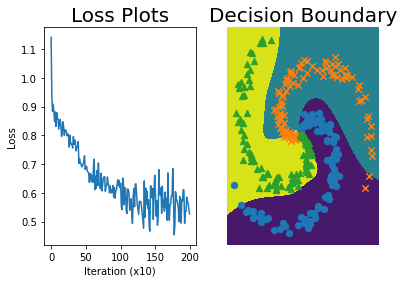

In [ ]:
# Plot Loss ----------------------------
fig, axes = plt.subplots(1,2)
axes[0].plot(np.arange(len(loss_list)), loss_list, label='train')
axes[0].set_title('Loss Plots', fontsize=20)
axes[0].set_xlabel('Iteration (x10)')
axes[0].set_ylabel('Loss')

# Decision Boundary
x, t = load_data(0) # Test dataset

h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
X = torch.Tensor(X)

with torch.no_grad():
  model.eval() # turn off dropout and batch_norm
  score = model.forward(X)
predict_cls = np.argmax(score.data.numpy(), axis=1)
Z = predict_cls.reshape(xx.shape)
axes[1].set_title('Decision Boundary', fontsize=20)
axes[1].contourf(xx, yy, Z)
axes[1].axis('off')

# Plot Data
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    axes[1].scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()